# Bike Sharing Problem

## Part 1
Please make an explorative data analysis and build a prediction model for the hourly utilization “cnt” of this data set: 

https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset. 

Your solution will consist of a short analysis (text ~ 1 DIN A4 with additional pages for plots) and the relevant code your report is about (source files).
-         In your report, present only one model, that you think is most suitable for a business-case.
Summarize your reasons for choosing this model.
Report the mean absolute deviations (MAD).
-         Assume that the code you are writing is used in production in a daily prediction service and maintained by your colleagues (what could that mean?)
Please do not spend more than a few hours on the topic. Your code and predictive model are of equal importance to us.

## Part 2
Above, you were asked to write a model for a small-to-medium data set. Can you outline how a solution would look like that is able to scale up? (half a page up to 1 page).
-         What are the scaling properties of your model, if you assume that the amount of data you need to handle go up to several terabytes? Do you see any problems?
-         How would you address these problems? Are there technologies for data storage/predictive modelling you can build upon? 
Describe how the technologies you mention solve the scaling problems you see with model.
-         What are the limits and drawbacks for your new approach?
-         Do you have hands-on experience with such technologies? Which ones? For how long?



### Dataset Attribute Description

Dataset information contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

#### Feature columns:
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
#### Label columns
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

#### Extraneous columns
- instant: record index

This notebook documents the analysis and model development for the Bike Sharing Dataset. It contains the following steps:

- About the Bike Sharing Dataset
- Descriptive Analysis
- Missing Value Analysis
- Outlier Analysis
- Correlation Analysis
- Unit testing
- Conclusion

In [1]:
## Loading required package
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import scipy.stats as stats
import scipy

import numpy as np
from numpy import average, std
from scipy import stats
from math import sqrt
from scipy.stats import t
import numpy as np, statsmodels.stats.api as sms

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from warnings import filterwarnings
filterwarnings('ignore')

## Load data

We start by loading our data, which is stored in Comma-Separated Value (CSV) format, into a dataframe.

In [2]:
base_dir = '/Users/chrisjcc/Desktop/DataInsight/DataChallenge/Bike-Sharing-Dataset/'
data_path = base_dir + 'hour.csv'

# Load data
data = pd.read_csv(data_path) 

In [3]:
# Check general schema-type
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
# Check dimensions of dataset
data.shape

print("Our dataset has %d rows and %d columns." % data.shape)

Our dataset has 17379 rows and 17 columns.


The dataset contains 17379 observed data points with 16 features (including target label).

In [5]:
# Print the first 10 samples of the dataset to explore the data
data.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


All of the columns except for the date (dteday) are numeric.

In [6]:
# list of attributes found in the dataset
list(data.columns)

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

We remove a feature that does not add important information, which in this case is only the “index” feature. Note cnt corresponds to total count of bike rented.

In [7]:
# Remove instant (record index)
data.drop('instant', axis=1, inplace=True)

In [8]:
number_features   = ['temp', 'atemp', 'hum', 'windspeed']
category_features = ['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']

features = category_features + number_features
target   = ['cnt']

### Data Exploration

Gain first impressions by explorating the data. We extract the data statistics for each feature column.

In [9]:
# Statistical summary of features that are continuous by nature (i.e. not categorical)
print(data[number_features].describe())

               temp         atemp           hum     windspeed
count  17379.000000  17379.000000  17379.000000  17379.000000
mean       0.496987      0.475775      0.627229      0.190098
std        0.192556      0.171850      0.192930      0.122340
min        0.020000      0.000000      0.000000      0.000000
25%        0.340000      0.333300      0.480000      0.104500
50%        0.500000      0.484800      0.630000      0.194000
75%        0.660000      0.621200      0.780000      0.253700
max        1.000000      1.000000      1.000000      0.850700


Note: as the temparerature-related features are normalize we will need to scale them back when plotting their distribution.

In [10]:
# Statistical summary of categorical features
print(data[category_features].astype('category').describe())

        season  holiday   mnth     hr  weekday  workingday  weathersit
count    17379    17379  17379  17379    17379       17379       17379
unique       4        2     12     24        7           2           4
top          3        0      7     17        6           1           1
freq      4496    16879   1488    730     2512       11865       11413


In [11]:
# Check for missing values (e.g. NULL) 
print(data.isnull().any())

dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool


In [13]:
# Check duplicates across all columns and rows (8645 rows)
data.duplicated(subset=None, 
                #keep='first'
               )
# Dropping ALL duplicte values (if any found)
data.drop_duplicates(subset=None, keep='first', inplace=False).head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


No missing values are found in the dataset no reason therefore to further explore if the data is missing Missing at Random (MAR), Missing Completely at Random (MCAR), or Missing Not at Random (MNAR), in order to determine if we need to remove data using for example Listwise/Pairwise deletion or do instead data Imputation. 

Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables.

Samples in train set with outliers: 17379
Samples in train set without outliers: 16874


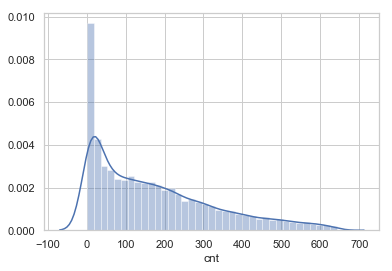

In [14]:
print("Samples in train set with outliers: {}".format(len(data)))
q1 = data.cnt.quantile(0.25)
q3 = data.cnt.quantile(0.75)

iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

train_preprocessed = data.loc[(data.cnt >= lower_bound) & (data.cnt <= upper_bound)]
print("Samples in train set without outliers: {}".format(len(train_preprocessed)))
sns.distplot(train_preprocessed.cnt);

This distribution plot of the count values confirms that the count values do not match a normal distribution, as it follows a poisson distribution. We can use the median and interquartile range (IQR) to identify and remove outliers from the data (as an option). If time permist we can compare model peformance between training the model w/o outlier data points to check performance boost.

### Data analysis


we can quickly make some plots to investigate how the bicycle usage count is affected by the features available. We are interested in predicting the number of rides, cnt, therefore we should look at the cnt distribution as it is a count variable we should expect a poison distribution, and so we can check this.

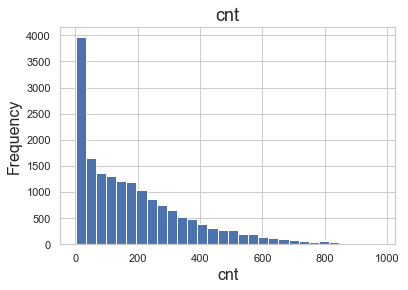

In [15]:
# Distribution of bike shares per day
data['cnt'].hist(bins=30)
plt.title('cnt', fontsize=18)
plt.xlabel('cnt', fontsize=16)
plt.ylabel('Frequency', fontsize=16);

Note that the overall range of user counts is between 0 to almost 700. From this plot we can assumed that the usage count follows a Poisson distribution and we can potentially use a Poisson Regression model.

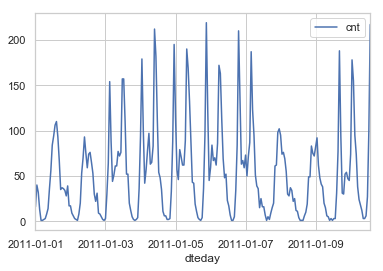

In [16]:
period = 24*10
data[:period].plot(x='dteday', y='cnt');

We will create a similar plot later to compare model predictions against held-out data. This will provide a visual of the behavior model compared to what is expected from the data. 

#### Visualize temparature distribution across seasons

Next, we calculated the mean, the median and the standard deviation of all seasons. We also convert the temperature, since the data of temperature was divided to 41. 

In [17]:
# Calculating Median, Mean and Standard deviation of winter
winter  = data.query('season == 1').temp 
wi_mean = np.mean(winter)*41
print(wi_mean)
wi_median = np.median(winter)*41
print(wi_median)
wi_sd = np.std(winter)*41
print(wi_sd)

# Calculating Median, Mean and Standard deviation of spring
spring = data.query('season == 2').temp
sp_mean = np.mean(spring)*41
print(sp_mean)
sp_median = np.median(spring)*41
print(sp_median)
sp_sd = np.std(spring)*41
print(sp_sd)

# Calculating Median, Mean and Standard deviation of summer
summer = data.query('season == 3').temp
su_mean = np.mean(summer)*41
print(su_mean)
su_median = np.median(summer)*41
print(su_median)
su_sd = np.std(summer)*41
print(su_sd)

# Calculating Median, Mean and Standard deviation of winter
fall = data.query('season == 4').temp
fa_mean = np.mean(fall)*41
print(fa_mean)
fa_median = np.median(fall)*41
print(fa_median)
fa_sd = np.std(fall)*41
print(fa_sd)

12.265011786892975
11.48
4.8671903959232505
22.331190746200953
22.96
5.707912058711943
28.962815836298926
28.7
3.849583559753113
17.348657844990548
17.22
5.0082710695401


Winter:
- The mean temperature of Winter was 12.27.
- The median temperature of Winter was 11.48.
- The standard deviation of the temperature in Winter was 4.87.

Spring:
- The mean temperature of Spring was 22.33.
- The median temperature of Spring was 22.96.
- The standard deviation of the temperature in Spring was 5.71.

Summer:
- The mean temperature of Summer was 28.96.
- The median temperature of Summer was 28.70.
- The standard deviation of the temperature in Summer was 3.85.

Fall:
- The mean temperature of Fall was 17.35.
- The median temperature of Fall was 17.22.
- The standard deviation of the temperature in Fall was 5.01.

Next we plot distributions displaying the temperatures of each season including lines for the mean and median temperatures.|

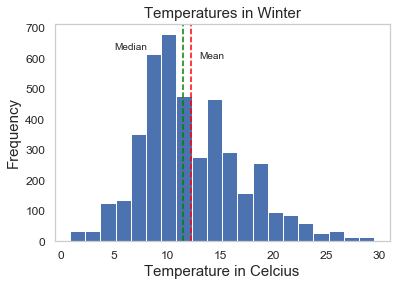

In [18]:
# Plot distribution of temperatures in Winter
winter.multiply(41).hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)
plt.title("Temperatures in Winter", size=15)
plt.xlabel("Temperature in Celcius", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.axvline(wi_mean, 0, 1, color='red', linestyle='--', label='Mean');
plt.text(13, 600,'Mean',rotation=0)
plt.axvline(wi_median, 0, 1, color='green', linestyle='--', label='Median');
plt.text(5, 630,'Median',rotation=0);

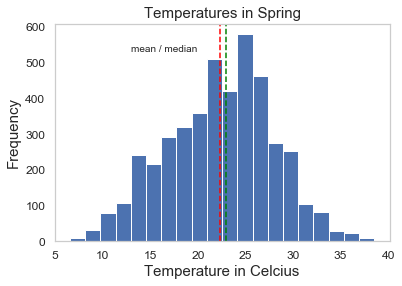

In [19]:
# Plot distribution of temperatures in Spring
spring.multiply(41).hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)
plt.title("Temperatures in Spring", size=15)
plt.xlabel("Temperature in Celcius", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.axvline(sp_mean, 0, 1, color='red', linestyle='--', label='mean')
plt.text(13, 530,'mean / median',rotation=0)
plt.axvline(sp_median, 0, 1, color='green', linestyle='--');

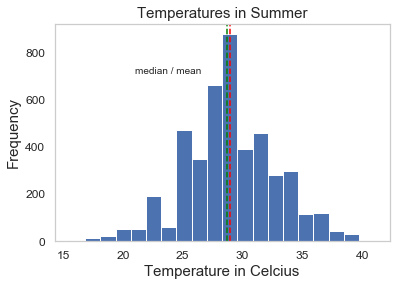

In [20]:
# Plot distribution of temperatures in Summer
summer.multiply(41).hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)
plt.title("Temperatures in Summer", size=15)
plt.xlabel("Temperature in Celcius", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.axvline(su_mean, 0, 1, color='red', linestyle='--')
plt.text(21, 710,'median / mean',rotation=0)
plt.axvline(su_median, 0, 1, color='green', linestyle='--');

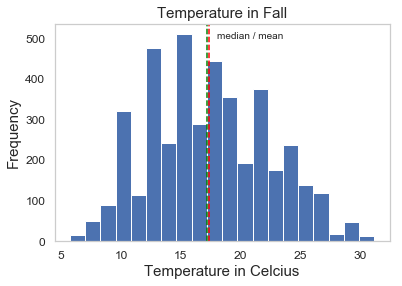

In [21]:
# Plot distribution of temperatures in Fall
fall.multiply(41).hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)
plt.title("Temperature in Fall", size=15)
plt.xlabel("Temperature in Celcius", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.axvline(fa_mean, 0, 1, color='red', linestyle='--')
plt.text(18, 500,'median / mean',rotation=0)
plt.axvline(fa_median, 0, 1, color='green', linestyle='--');

#### Visualize weather based distributions montly aggregate

Let's look at the distribution for temperature, humidity, windspeed and total rentals per months.

In [22]:
data_agg = pd.concat([data.groupby('mnth')['cnt'].mean(),
                      data.groupby('mnth')['windspeed'].mean(),
                      data.groupby('mnth')['hum'].mean(),
                      data.groupby('mnth')['temp'].mean()
                     ], 
                     axis=1, 
                     join='outer',
                     ignore_index=True)

data_agg = data_agg.rename(columns={0: "mean_rentals",
                                    1: "mean_windspeed", 
                                    2: "mean_hum", 
                                    3: "mean_temp"}).reset_index()
data_agg.head(12)

,mnth,mean_rentals,mean_windspeed,mean_hum,mean_temp
0,1,94.424773,0.207551,0.580931,0.237649
1,2,112.865026,0.215961,0.567211,0.300209
2,3,155.410726,0.222517,0.589050,0.390903
3,4,187.260960,0.234323,0.588114,0.470021
4,5,222.907258,0.182989,0.688958,0.594798
5,6,240.515278,0.185420,0.575806,0.684097
6,7,231.819892,0.166059,0.597876,0.755470
7,8,238.097627,0.171468,0.637227,0.708705
8,9,240.773138,0.165856,0.714454,0.616507
9,10,222.158511,0.171919,0.689490,0.487181


We observe an increase in mean rentals over the year up to about September and then a decrease this might reflect winter whether discouraging bike usage and end of year holidays.

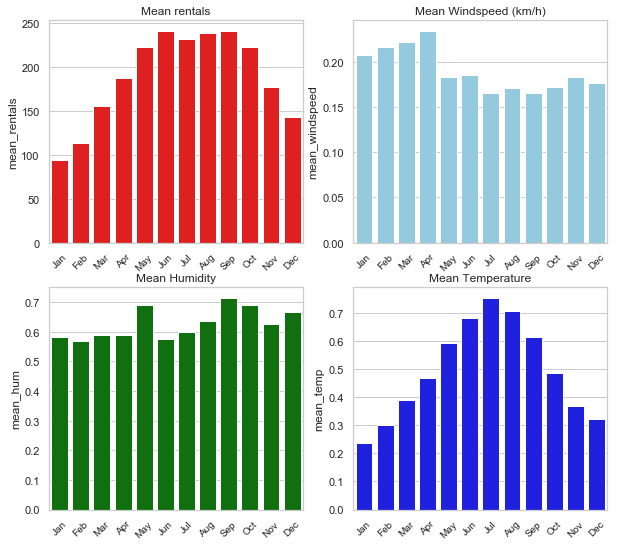

In [23]:
f, axes = plt.subplots(2, 2)
f.set_size_inches(10, 9)

# Plotting the different means associated with month
sns.barplot(x="mnth",
            y="mean_rentals", 
            data=data_agg, 
            color="red",
            ax=axes[0][0]
            )
sns.barplot(x="mnth", 
            y="mean_windspeed", 
            data=data_agg, 
            color="skyblue",
            ax=axes[0][1]
            )
sns.barplot(x="mnth", 
            y="mean_hum", 
            data=data_agg, 
            color="green",
            ax=axes[1][0]
            )
sns.barplot(x="mnth", 
            y="mean_temp", 
            data=data_agg, 
            color="blue",
            ax=axes[1][1],
            )

label_text = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0][0].set_xticklabels(label_text, rotation=45, fontsize=10);
axes[0][0].set_title("Mean rentals");
axes[0][0].set(xlabel='');


axes[0][1].set_xticklabels(label_text, rotation=45, fontsize=10);
axes[0][1].set_title("Mean Windspeed (km/h)");
axes[0][1].set(xlabel='');

axes[1][0].set_xticklabels(label_text, rotation=45, fontsize=10);
axes[1][0].set_title("Mean Humidity");
axes[1][0].set(xlabel='')

axes[1][1].set_xticklabels(label_text, rotation=45, fontsize=10);
axes[1][1].set_title("Mean Temperature");
axes[1][1].set(xlabel='');

As we can see both mean-rental and mean temerature have guassian-like distrubtion with a heavy tail on the left, while mean windspeed and humidity are more unitformally distrubted with minor peaks.

#### Bike usage across month, season, hourly, and work week 

We notice that the average check out number on weekdays is relatively smaller than that during Saturday, and Monday having the largest variability.

In [24]:
x = data
x["temp"] = x["temp"].multiply(41).round(1)

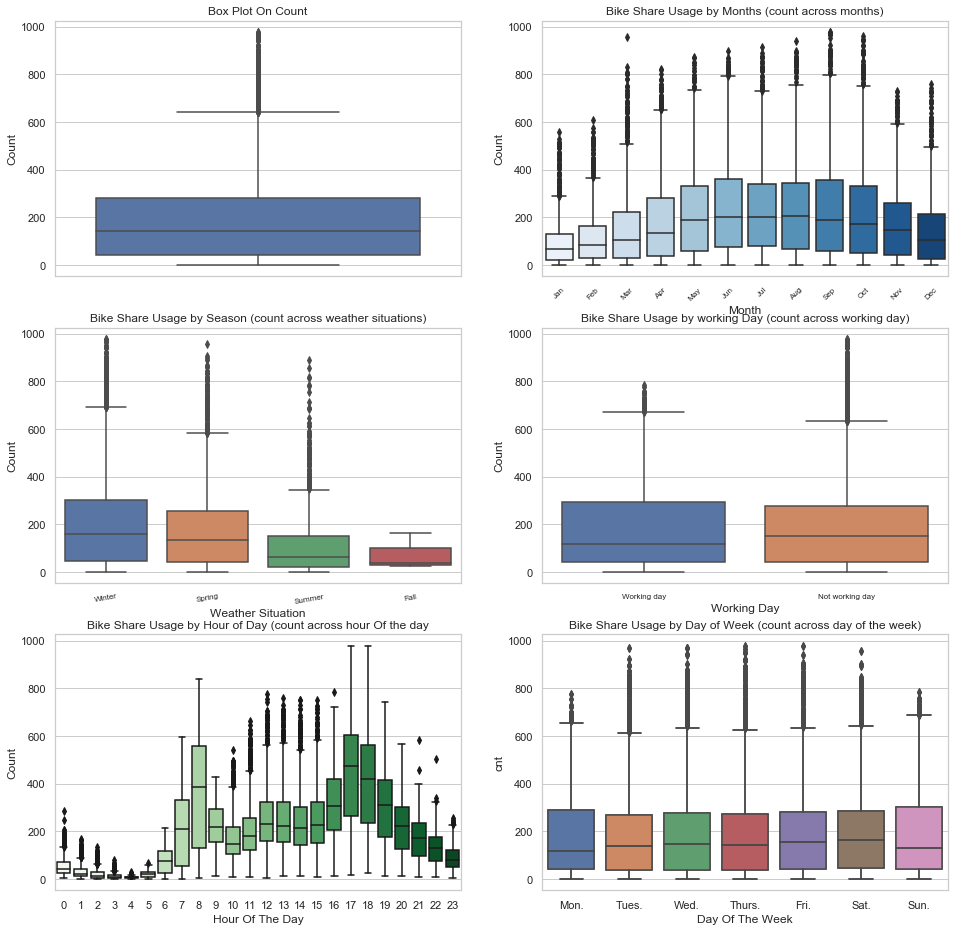

In [25]:
# Set sub-plot configuration
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(16, 16)

# cnt count
sns.boxplot(data=x, y="cnt", orient="v", ax=axes[0][0])

# Monthly bike share usage by month
sns.boxplot(data=x, y="cnt", x="mnth", orient="v", ax=axes[0][1], palette="Blues")

# Bike share usage by season
sns.boxplot(data=x, y="cnt", x="weathersit", orient="v", ax=axes[1][0])

# Bike share usage by weekday
sns.boxplot(data=x, y="cnt", x="workingday", orient="v", ax=axes[1][1])
sns.boxplot(data=x, y="cnt", x="hr", orient="v", ax=axes[2][0], palette="Greens")

# Bike share usage by weekday: cnt count per weekday
sns.boxplot(data=data, x="weekday", y="cnt",orient="v", ax=axes[2][1])

axes[0][0].set(ylabel='Count', title="Box Plot On Count")
axes[0][1].set(xlabel='Month', ylabel='Count',title="Bike Share Usage by Months (count across months)")

label_text = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0][1].set_xticklabels(label_text, rotation=45, fontsize=8);
axes[1][0].set(xlabel='Weather Situation', ylabel='Count', title="Bike Share Usage by Season (count across weather situations)")

label_text = ['Winter', 'Spring', 'Summer', 'Fall']
axes[1][0].set_xticklabels(label_text, rotation=10, fontsize=8);
axes[1][1].set(xlabel='Working Day', ylabel='Count', title="Bike Share Usage by working Day (count across working day)")

label_text = ['Working day', 'Not working day']
axes[1][1].set_xticklabels(label_text, rotation=0, fontsize=8);
axes[2][0].set(xlabel='Hour Of The Day', ylabel='Count', title="Bike Share Usage by Hour of Day (count across hour Of the day")

sns.boxplot(data=data, x="weekday", y="cnt",orient="v", ax=axes[2][1])
axes[2][1].set(xlabel='Day Of The Week', ylabel='cnt', title="Bike Share Usage by Day of Week (count across day of the week)");
labels = ['Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.', 'Sun.']
axes[2][1].set_xticklabels(labels);

Looking at the effects of time (i.e. bike share usage by hour of day), it seems that the lowest usage is late at night (with the minimum between 4–5 am) and the peaks are during 8–9 am and 5–7 pm, which are unsurprisingly as those are time times for rush hour.

A similar trend can also be observed in the month vs usage plot (i.e. bike share usage by months), with an evidently higher usage rate during the warmer months of the summer and the lowest usage during January.


We observe the check out number over time on a weekday (i.e. bike share usage by day of week) which varies dramatically. There are two peaks at around 08:00
and 16:00. Since a significant portion of users rent bicycles for fixed purposes (e.g., commute), time of day is also considered as a feature in the model.

There are two additional features that are associated with date: weekday and holiday. These are binary indicators representing whether a particular day is a weekday or holiday.

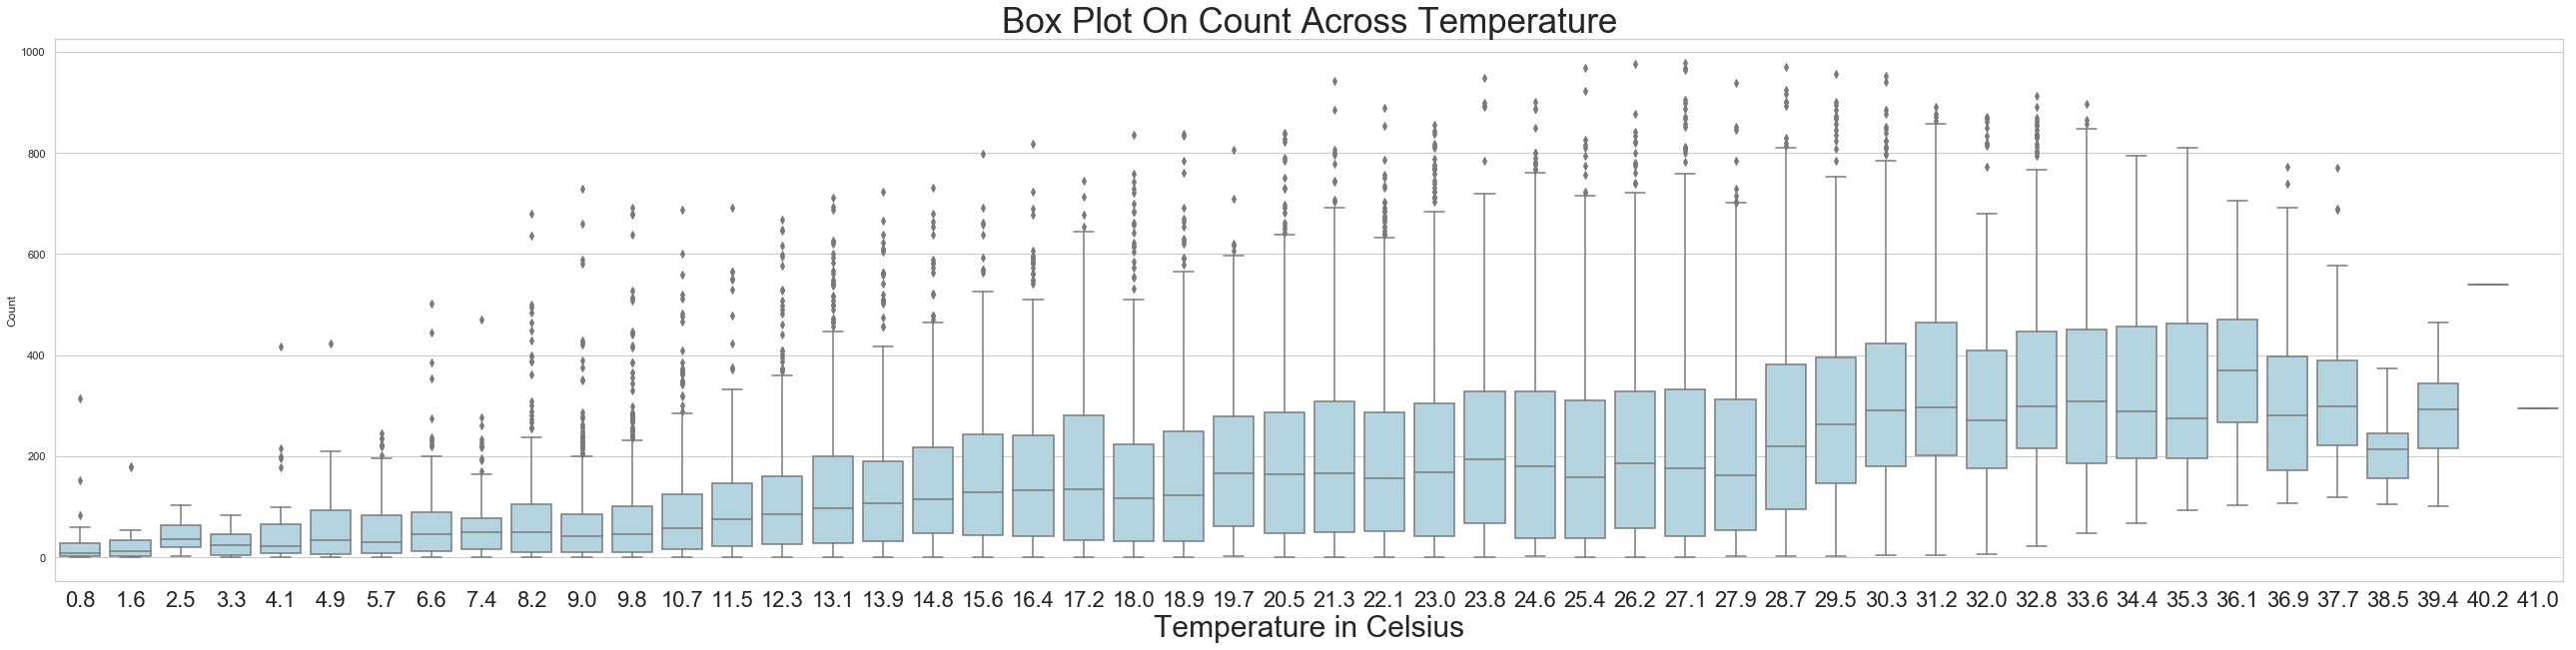

In [26]:
# Reproducing last Temperature plot

# cnt count per week day
fig, ax = plt.subplots()
fig.set_size_inches(45, 10)

s = sns.boxplot(data=x, y="cnt", x="temp", orient="v", ax=ax, color='lightblue')
ax.set(xlabel='Temperature', ylabel='Count', title="Bike Share Usage by Temperature (count across temperature");
ax.set_xlabel("Temperature in Celsius", fontsize=30)
ax.set_title("Box Plot On Count Across Temperature", fontsize=35);
ax.set_xticklabels(s.get_xticklabels(), fontsize=22);

We observe from the plot above that the bike usage increases with increasing temperature up to a point, around 31-32 degrees Celsius, then decreses, which makes sense as a person would like to avoid heat exhaustion. 

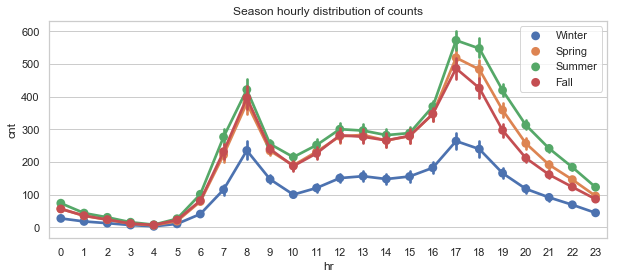

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
sns.pointplot(data=data[['hr', 'cnt','season']],
              x='hr',
              y='cnt',
              hue='season',
              ax=ax)
ax.set(title="Season hourly distribution of counts");
legend_lables = ['Winter', 'Spring', 'Summer', 'Fall']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, legend_lables);

We seee similar profiles across the seasons, mainly that during the morning and evening we observe peak bike usage which we can safely assume are commuting to and from work. 

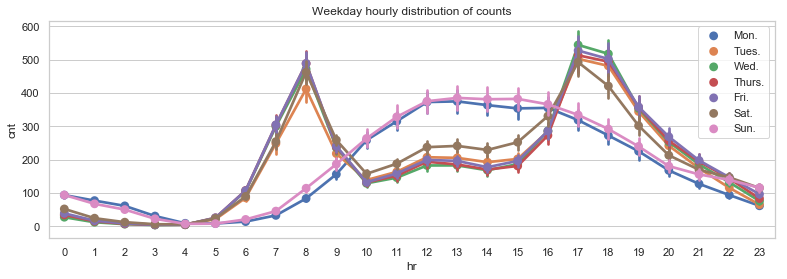

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 4)
sns.pointplot(data=data[['hr','cnt', 'weekday']],
              x='hr',
              y='cnt',
              hue='weekday',
              ax=ax)
ax.set(title="Weekday hourly distribution of counts")
legend_lables = ['Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.', 'Sun.']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, legend_lables);

As what we might expect the profile trened between week day and weekend differ as the morning and evening peaks disapear which since they correspond to commutors, while now we see main usage during 11am-5pm roughly which is the bulk of the recreational time people enjoy riding bikes.

#### Affect of temperature on bike usage

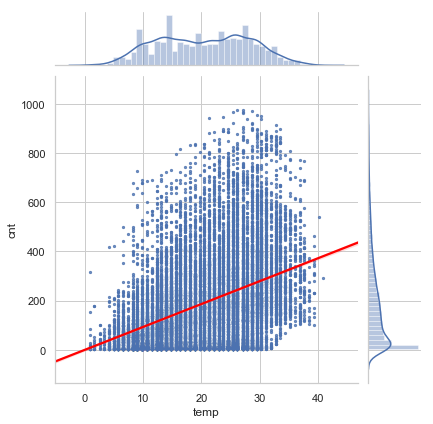

In [29]:
# Affect of felt temperature on bike share usage:
# plot the temp and resulting regression line and a 95% confidence interval for the regression
with sns.axes_style('whitegrid'):
    sns.jointplot(x="temp", y="cnt", data=data, kind="reg",
                  joint_kws={'line_kws':{'color':'red'}},
                  scatter_kws={"s": 5});

As seen from the scatter plots above, there is a positive correlation between both temperature-to-usage and adjusted-temperature-to-usage for most of the temperature range, and a linear fit isn’t far from the best-fit curve. This should intuitively make sense, as people are not likely to bike outside in cold weather. For the maximum temperatures, which seem to be a small subset of the data, there is a dip in this curve. Once again, this should make sense as users may also be discouraged to bike when it’s too hot outside.

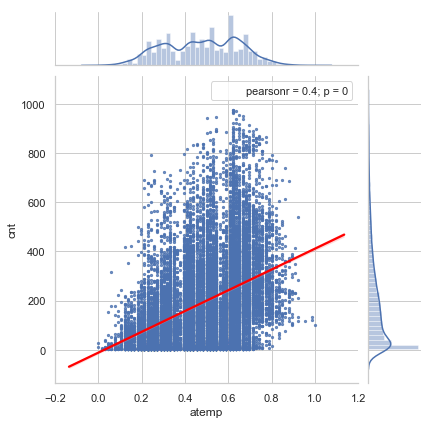

In [30]:
# plot atemp and resulting regression line and a 95% confidence interval for the regression
with sns.axes_style('whitegrid'):
    sns.jointplot(x="atemp", y="cnt", data=data, kind="reg",
                  joint_kws={'line_kws':{'color':'red'}},
                  scatter_kws={"s": 5}).annotate(stats.pearsonr);

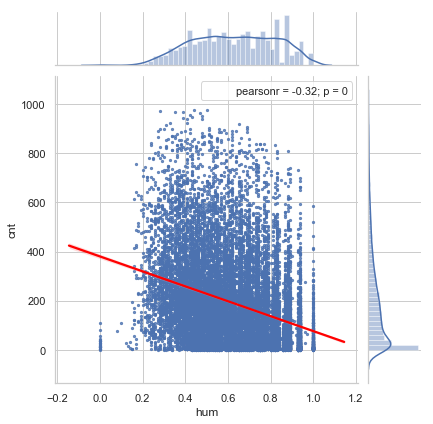

In [31]:
# plot humidity and resulting regression line and a 95% confidence interval for the regression
with sns.axes_style('whitegrid'):
    sns.jointplot(x="hum", y="cnt", data=data, kind="reg",
                  joint_kws={'line_kws':{'color':'red'}},
                  scatter_kws={"s": 5}).annotate(stats.pearsonr);

There seems to be a negative correlation between the humidity and the usage rate, with a linear fit being very close to the best curve fit for all of the data. This could be explained by the climate which have high levels of humid. Higher humidity is correlated with higher chances of rainfall.

Based on the plots above, it wouldn’t be unreasonable for us to hypothesize that the weather-situation will affect the bike usage, with rainfall deterring usage. We explore other plots to support this hypothesis to an extent.

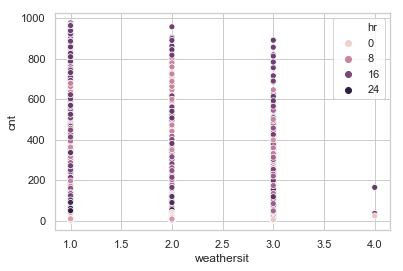

In [32]:
# Scatter plot: weather situation vs usage
ax = sns.scatterplot(x="weathersit", y="cnt", hue="hr", data=data)

From the plot we see that there are many more clear days (weather situtation equals to 1) than overcast or rainy days (weather situation with 2 or 3 respectively).

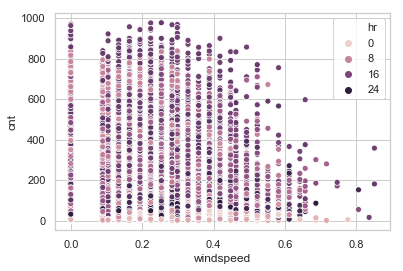

In [33]:
# Scatter plot: wind-speed vs usage
ax = sns.scatterplot(x="windspeed", y="cnt", hue="hr", data=data)

Looking at the wind speed data, however, doesn’t give us a clear interpretation of how it affects usage. The correlation between the two factors is weak at best.

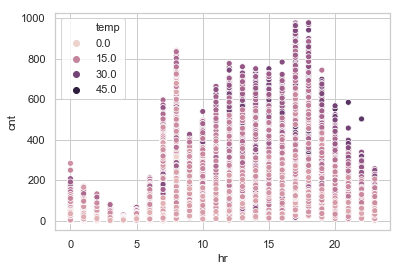

In [34]:
# Scatter plot: hour vs usage
ax = sns.scatterplot(x="hr", y="cnt", hue="temp", data=data)

Weather condition has a huge influence on user behaviors in bike-renting transportation. As we observe in the above plot the check out numbers grow when people feel more comfortable at higher temperatures. Similar patterns exist for other Weather conditions such as humidity, visibility and wind speed. Nevertheless, these patterns vary with time and across stations. For example, renters’ check out behaviors are less influenced by weather
conditions during peak hours.

#### Understanding mean bike usage across time

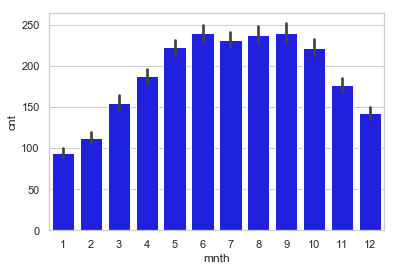

In [35]:
# Plotting the different means associated with month
ax = sns.barplot(x="mnth", y="cnt", 
                 data=data, 
                 #estimator="sd",
                 #capsize=.1
                 color="blue"
                )

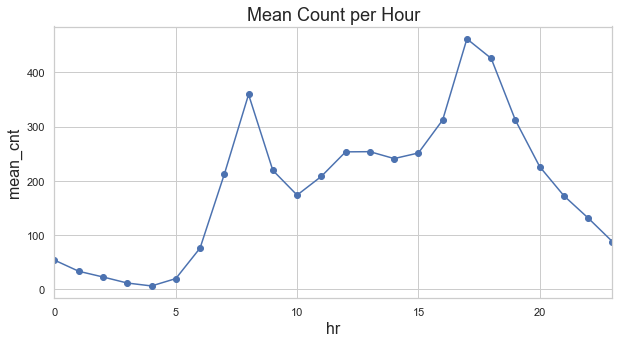

In [36]:
# Distribution of mean count per hour
data.groupby('hr')['cnt'].mean().plot(marker='o', figsize=(10,5)) 
plt.title('Mean Count per Hour', fontsize=18)
plt.xlabel('hr', fontsize=16)
plt.ylabel('mean_cnt', fontsize=16);

As expected, rentals are low during the night, and they peak in the morning (8am) and in the early evening (6pm). This indicates the hr feature is useful and can help us predict our label cnt. 

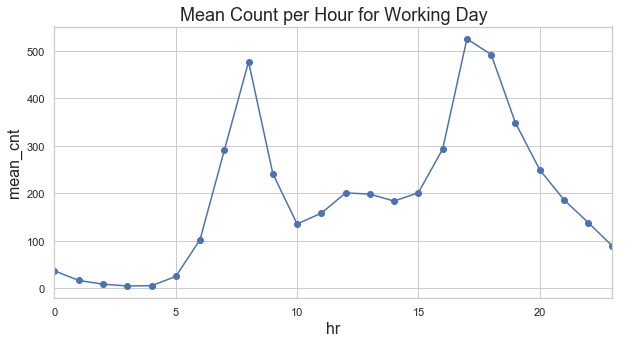

In [37]:
# Distribution of mean count per hour for when workingday day is neither weekend nor holiday
data.query('workingday==1').groupby('hr')['cnt'].mean().plot(marker='o', figsize=(10,5)) 
plt.title('Mean Count per Hour for Working Day', fontsize=18)
plt.xlabel('hr', fontsize=16)
plt.ylabel('mean_cnt', fontsize=16);

We observe two peaks corresponding to periods of day where bikes are used to commute to work (approx. 7-9 am) and commuting back hom between (approx. 17-19pm).

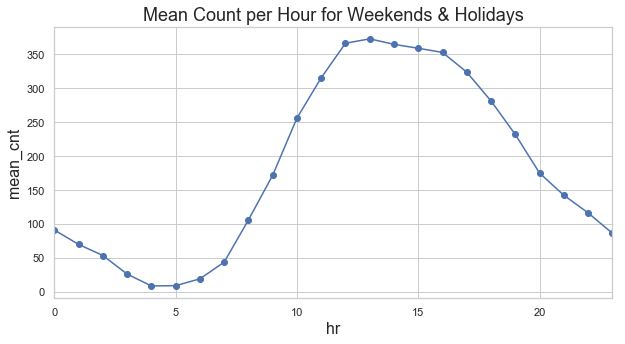

In [38]:
# Distribution of mean count per hour for when workingday day is either weekend or holiday (e.g. weekends)
data.query('workingday==0').groupby('hr')['cnt'].mean().plot(marker='o', figsize=(10,5)) 
plt.title('Mean Count per Hour for Weekends & Holidays', fontsize=18)
plt.xlabel('hr', fontsize=16)
plt.ylabel('mean_cnt', fontsize=16);

As we can see by comparing the above two plots the mean bike usage profile between weekday and weekend are quite different as we would expect as the weekened most bike usage would be for recreational purposes.

In [39]:
# Correlation matrix of input variables
def correlation_matrix(data, target='y',**kwds):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss
    Parameters
    ----------
    data : array, shape = [n_samples]
    kwds : array, shape = [n_samples, n_classes]
        
    Returns
    -------
    plt : canvas
    """
        
    
    """To calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
 
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    labels = data.corr(**kwds).columns.values
    
    fig, ax1 = plt.subplots(ncols=1, figsize=(7,7))
    
    opts = {"annot" : True,
            "ax" : ax1,
            "vmin": 0, "vmax": 1*100,
            "annot_kws" : {"size": 13}, 
            "cmap": plt.get_cmap("Blues", 20),
            }
    
    ax1.set_title("Correlations")

    sns.heatmap(data.corr(method="spearman").iloc[::-1]*100, 
                square=True,
                **opts) 
        
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels[::-1], minor=False, ha="right", rotation=70)
        #ax.set_yticklabels(np.flipud(labels), minor=False)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
        
    return plt.show()

#### Pearson's correlation across features

Below is a correlation-matrix of all the features variables. We can check if there is a correlation between the for example temp, windspeed, and the total count of bike rentals?

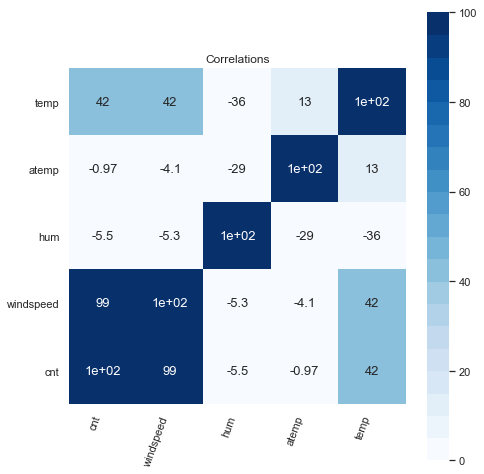

In [40]:
# Correlation plot
correlation_matrix(data[number_features + target])

- The variables "temp" and "atemp" are strongly correlated. 
- To reduce the dimensionality of the predictive model, the feature "atemp" maybe dismissed.
- The variables "windspeed" and "temp" seem to be promising features for the bike sharing count prediction.

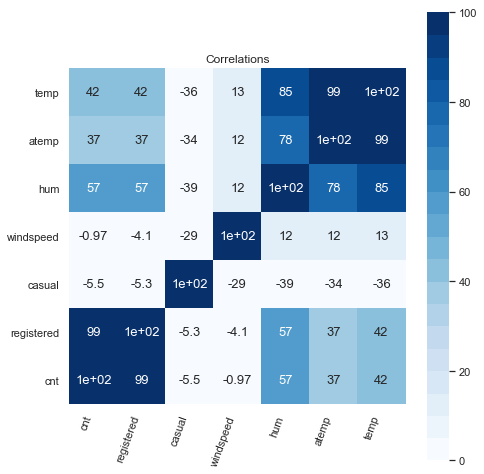

In [41]:
# Correlation plot
correlation_matrix(data[ ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'] + target])

The casual usage count is more correlated with the continuous variables and aligns better with our previous hypotheses. It makes sense if we think about it, as registered users who use bikes to commute to work are less likely to be deterred by uncomfortable weather conditions. We may conclude that it makes more sense to predict these two counts separately and add up the tallies to find the total count. 

#### Comparing temperature and feeled temperature

We can check if there is a difference between the real temperature and the feeled temperature. And check if there is a difference will it still be there across the different seasons. We can use t-test statistics to verify.

In [42]:
# Scale up atemp by 41 as was done with temp feature
x["atemp"] = x["atemp"].multiply(41).round(1)

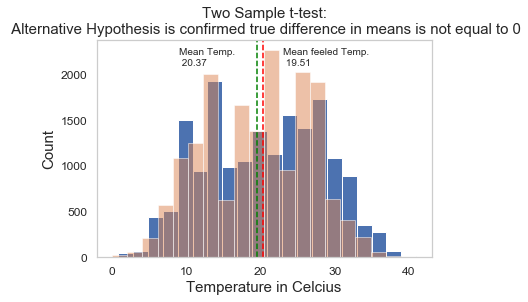

In [43]:
# Extract temp and atemp sample mean
temp_mean = x.temp.mean()
atemp_mean = x.atemp.mean()
diff_mean = temp_mean - atemp_mean

# Plot distribution of temperatures
x.temp.hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12)
x.atemp.hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12, alpha=0.5)

plt.title("Two Sample t-test:\n Alternative Hypothesis is confirmed true difference in means is not equal to 0", size=15)
plt.xlabel("Temperature in Celcius", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.axvline(temp_mean, 0, 1, color='red', linestyle='--')
plt.text(9, 2100,'Mean Temp.\n %.2f' % (temp_mean), rotation=0)
plt.axvline(atemp_mean, 0, 1, color='green', linestyle='--')
plt.text(23, 2100,'Mean feeled Temp.\n %.2f' % (atemp_mean), rotation=0);

We can use Student’s T-Test statitics to compares two averages and tells if they are different from each other. The t-test also tells how significant the differences are; In other words it lets you know if those differences could have happened by chance. An Independent Samples t-test compares the means for two groups. A small t-score tells you that the groups are similar. And A large t-score tells you that the groups are different.

A p-value is the probability that the results from your sample data occurred by chance. Low p-values are good; They indicate that the data did not occur by chance. For example, a p-value of .05 means there is only a 5% probability that the results from an experiment happened by chance. In most cases, a p-value of 0.05 (5%) is accepted to mean the data is valid.

In [44]:
# A Two-sample-t-test for real temperature and feeled temperature.
fina = sms.ttest_ind(x.temp, x.atemp, 
                     alternative='two-sided', 
                     usevar='unequal' # perform Welch’s t-test, which does not assume equal population variance
                    )

print("The t-statistic is %.3f the p-value is %.3f and the df is %.3f" % fina)

The t-statistic is 10.789 the p-value is 0.000 and the df is 34317.515


In [45]:
# two-sided confidence interval for weighted mean of data
diff = x.temp - x.atemp
sms.DescrStatsW(diff).tconfint_mean(alpha=0.05, # significance level for the confidence interval
                                    alternative='two-sided')

(0.8445739076056287, 0.8876316278106806)

In [46]:
N = len(x['temp'])       # sample size
gamma=0.95               # confidence level
ddof     =  2*N - 2      # the degree used is N - ddof
mu_hat   = np.mean(diff) # sample mean
sigma_hat= np.std(diff)  # sample standard deviation

print('sample mean mu_hat                  : %f' % mu_hat)
print('sample standard deviation sigma_hat : %f' % sigma_hat)
l=scipy.stats.t.ppf((1-gamma)/2, ddof)    # lower percentile
u=scipy.stats.t.ppf(1-(1-gamma)/2, ddof)  # upper percentile

print('confidence interval mu_hat: (%f, %f)' % 
      (mu_hat+l*sigma_hat/sqrt(N), mu_hat+u*sigma_hat/sqrt(N)))

sample mean mu_hat                  : 0.866103
sample standard deviation sigma_hat : 1.447913
confidence interval mu_hat: (0.844575, 0.887630)


In [124]:
# Calculate the lower and uppper bound of the confidence interval
def Confidence_Interval(x_1, x_2):
    data = x_1 - x_2
    mean = average(data)
    
    # Run independent t-test: A Two-sample-t-test for real temperature and feeled temperature.
    t_test, p_value, dof = sms.ttest_ind(x_1, x_2, 
                     alternative='two-sided', 
                     usevar='unequal' # perform Welch’s t-test, which does not assume equal population variance
                    )
    print("The t-statistic is %.3f the p-value is %.3f" % (t_test, p_value))
    
    # evaluate sample variance by setting delta degrees of freedom (ddof) to
    stddev = std(data, ddof=1)
    
    # Get the endpoints of the range that contains 95% of the distribution
    t_bounds = t.interval(0.95, len(data) - 1)
    
    # sum mean to the confidence interval
    ci = [mean + critval * stddev / sqrt(len(data)) for critval in t_bounds]
    sms.CompareMeans(sms.DescrStatsW(x_1),
                     sms.DescrStatsW(x_2).tconfint_diff(alpha=0.05, 
                                                        alternative='two-sided',
                                                        usevar='unequal'))
    
    # The degree used in calculations is N - ddof
    dof = len(data) - 1
    
    print('Degrees of freedom: %d' % dof)
    print "Mean: %f" % mean
    print "Confidence Interval 95%%: %f, %f" % (ci[0], ci[1])

In [131]:
# Calculate the lower and uppper bound of the confidence interval
def ConfidenceInterval(x_1, x_2, label='The mean of the temp and atemp variables are %.2f and %.2f'):
    
    '''
    @param: 
        - x_1: sample dataset 1
        - x_2: sample dataset 2
        
    return:
        - Null
    '''
    confidence = 0.95
    
    data = x_1 - x_2
    n = len(data)
    m = np.mean(data)
    std_err = np.std(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)

    lower = m - h
    upper = m + h
    
    # The mean of the variables
    print(label %( x_1.mean(), x_2.mean()))
    
    # Run independent t-test: A Two-sample-t-test for real temperature and feeled temperature.
    t_test, p_value, dof = sms.ttest_ind(x_1, x_2, 
                     alternative='two-sided', 
                     usevar='unequal' # perform Welch’s t-test, which does not assume equal population variance
                    )
    print("The t-statistic is %.3f the p-value is %.3f" % (t_test, p_value))
    
    # The degree used in calculations is N - ddof
    dof = len(data) - 1
    
    print('Degrees of freedom: %d' % dof)
    print("Mean: %f" % m)

    # Print 95% CI
    print("lower and upper bound of confidence interval: [%.2f, %.2f]" % (lower, upper))

In [49]:
# A Two-sample-t-test for real temperature and feeled temperature.
ConfidenceInterval(x.temp, x.atemp)

The mean of the temp and atemp variables are 20.37 and 19.51
The t-statistic is 10.789 the p-value is 0.000
Degrees of freedom: 17378
Mean: 0.866103
lower and upper bound of confidence interval: [-1.97, 3.70]


In [50]:
# A Two-sample-t-test for real temperature and feeled temperature in winter
ConfidenceInterval(x.query("season==1")['temp'], x.query("season==1")['atemp'])

The mean of the temp and atemp variables are 12.26 and 12.22
The t-statistic is 0.372 the p-value is 0.710
Degrees of freedom: 4241
Mean: 0.038567
lower and upper bound of confidence interval: [-1.90, 1.97]


In [51]:
# A Two-sample-t-test for real temperature and feeled temperature in spring
ConfidenceInterval(x.query("season==2")['temp'], x.query("season==2")['atemp'])

The mean of the temp and atemp variables are 22.33 and 21.35
The t-statistic is 8.556 the p-value is 0.000
Degrees of freedom: 4408
Mean: 0.983216
lower and upper bound of confidence interval: [-1.01, 2.98]


In [52]:
# A Two-sample-t-test for real temperature and feeled temperature in summer
ConfidenceInterval(x.query("season==3")['temp'], x.query("season==3")['atemp'])

The mean of the temp and atemp variables are 28.96 and 26.90
The t-statistic is 25.986 the p-value is 0.000
Degrees of freedom: 4495
Mean: 2.061477
lower and upper bound of confidence interval: [-1.27, 5.39]


In [53]:
# A Two-sample-t-test for real temperature and feeled temperature in fall
ConfidenceInterval(x.query("season==4")['temp'], x.query("season==4")['atemp'])

The mean of the temp and atemp variables are 17.35 and 17.04
The t-statistic is 2.938 the p-value is 0.003
Degrees of freedom: 4231
Mean: 0.303639
lower and upper bound of confidence interval: [-1.61, 2.22]


Across all seasons:
- The t-statistic was 10.79.
- p-value is 0.000
- The mean of the temp and atemp variables are 20.37 and 19.51.
- The parameters are (degreess of freedom) 17378.
- The 95% confidence intervall is -1.97, 3.70.

Spring: 
- The t-statistic was 0.372.
- the p-value is 0.710
- The mean of the temp and atemp variables in spring are 12.26 and 12.22.
- The parameters are (degreess of freedom) 4241.
- The 95% confidence intervall is -1.90, 1.97.

Summer:    
- The t-statistic was 8.556.
- p-value is 0.000
- The mean of the temp and atemp variables in summer are 22.33 and 21.35.
- The parameters are (degreess of freedom) 2202.
- The 95% confidence intervall is -1.01, 2.98.

Fall:
- The t-statistic was 25.986.
- p-value is 0.000
- The mean of the temp and atemp variables in fall are 28.96 and 26.90.
- The parameters are (degreess of freedom) 4495.
- The 95% confidence intervall is -1.27, 5.39.

Winter:
- The t-statistic was 2.938.
- p-value is 0.003.
- The mean of the temp and atemp variables in winter are 17.35 and 17.04.
- The parameters are (degreess of freedom) 2133.
- The 95% confidence intervall is -1.71, 2.39.

### How weather condition effects rental rates
We will create histograms for each weather condition to explore distribution of the bike rentals by weather condition.

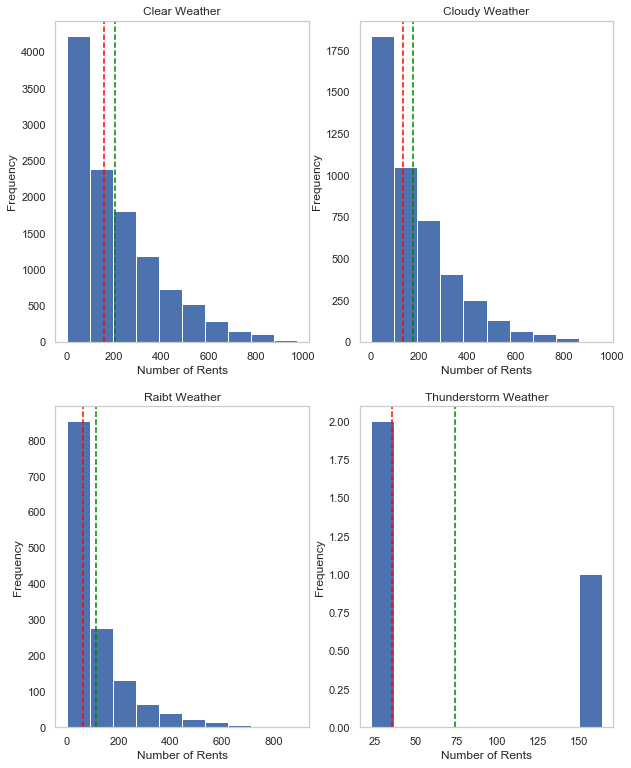

In [103]:
# Set sub-plot configuration (reate 4 histograms)
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 13)

# Clear Weather  count
data.query("weathersit == 1")['cnt'].hist(bins=10, grid=False,  ax=axes[0][0])
axes[0][0].set(xlabel='Number of Rents', ylabel='Frequency')
axes[0][0].set_title('Clear Weather')
# add verticle lines indicating meadian and mean value
axes[0][0].axvline(data.query("weathersit == 1")['cnt'].median(), 0, 1, color='red', linestyle='--')
axes[0][0].axvline(data.query("weathersit == 1")['cnt'].mean(), 0, 1, color='green', linestyle='--')

# Cloudy Weather count
data.query("weathersit == 2")['cnt'].hist(bins=10, grid=False,  ax=axes[0][1])
axes[0][1].set(xlabel='Number of Rents', ylabel='Frequency')
axes[0][1].set_title('Cloudy Weather')
# add verticle lines indicating meadian and mean value
axes[0][1].axvline(data.query("weathersit == 2")['cnt'].median(), 0, 1, color='red', linestyle='--')
axes[0][1].axvline(data.query("weathersit == 2")['cnt'].mean(), 0, 1, color='green', linestyle='--')

# Clear Rainy Weather count
data.query("weathersit == 3")['cnt'].hist(bins=10, grid=False,  ax=axes[1][0])
axes[1][0].set(xlabel='Number of Rents', ylabel='Frequency')
axes[1][0].set_title('Raibt Weather')
# add verticle lines indicating meadian and mean value
axes[1][0].axvline(data.query("weathersit == 3")['cnt'].median(), 0, 1, color='red', linestyle='--')
axes[1][0].axvline(data.query("weathersit == 3")['cnt'].mean(), 0, 1, color='green', linestyle='--')

# Clear Thunderstorm Weather count
data.query("weathersit == 4")['cnt'].hist(bins=10, grid=False,  ax=axes[1][1])
axes[1][1].set(xlabel='Number of Rents', ylabel='Frequency')
axes[1][1].set_title('Thunderstorm Weather')
# add verticle lines indicating meadian and mean value
axes[1][1].axvline(data.query("weathersit == 4")['cnt'].median(), 0, 1, color='red', linestyle='--')
axes[1][1].axvline(data.query("weathersit == 4")['cnt'].mean(), 0, 1, color='green', linestyle='--')

The histograms demonstrate that distribution of the bike rents for Clear and Cloudy weather is pretty similar (although the frequency is much higher in the first case), while differs significantly for Rainy weather and drastically for Thunderstorm weather, where, as it was already pointed out, the frequency being extremely low.

In [104]:
data.columns

Index([u'dteday', u'season', u'yr', u'mnth', u'hr', u'holiday', u'weekday',
       u'workingday', u'weathersit', u'temp', u'atemp', u'hum', u'windspeed',
       u'casual', u'registered', u'cnt'],
      dtype='object')

Text(0.5,1,u'holiday')

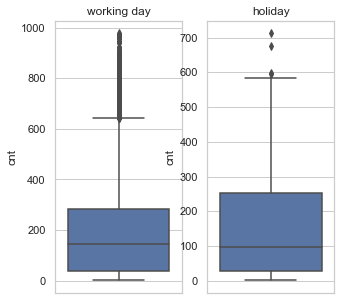

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False)
fig.set_size_inches(5, 5)

# cnt count
sns.boxplot(data=x.query("holiday==0"), y="cnt", orient="v", ax=axes[0][0]).set_title('working day')
sns.boxplot(data=x.query("holiday==1"), y="cnt", orient="v", ax=axes[0][1]).set_title('holiday')

In [137]:
# A Two-sample-t-test for mean comparison between holiday and working day.
fina = sms.ttest_ind(data.query("holiday == 0 and workingday==1")['cnt'], data.query("holiday == 1")['cnt'], 
                     alternative='two-sided', 
                     usevar='unequal' # perform Welch’s t-test, which does not assume equal population variance
                    )

print("The t-statistic is %.3f the p-value is %.3f and the df is %.3f" % fina)

The t-statistic is 5.038 the p-value is 0.000 and the df is 559.286


In accordance with the conducted t-test, there is a significant difference between total bike rentals on holidays and working days (p=value < 0.01). The bar-plot shows that the maximum number of rents is significantly higher for working days than for holidays, while the frequency of moderate numbers of bike rentals (200-600 rentals) is higher for holidays.

### Data Preparation for model building

#### Features:
- Some of the columns contain duplicate information. For example, the cnt column we want to predict equals the sum of the casual + registered columns. We will remove the casual and registered columns from the data to make sure we do not use them to predict cnt. 
- Date column dteday: we could keep it, but it is well-represented by the other date-related columns season, yr, mnth, and weekday. We will discard it.
- row index column instant: This is a useless column to us.

In [ ]:
data = data.drop("instant").drop("dteday").drop("casual").drop("registered")

### Unit tests 

Run these unit tests to check the correctness of the model/network implementation. This will help to be sure the model/network was implemented correctly before we starting trying to train it. These tests must all be successful to pass the project.

In [ ]:
import unittest

In [ ]:
class TestMethods(unittest.TestCase):
    
    ##########
    # Unit-tests for data loading
    ##########
    
    def test_data_path(self):
        # test that file path to dataset has been unaltered
        self.assertTrue(data_path == '/Users/chrisjcc/Downloads/hour.csv')
        
    def test_data_loaded(self):
        # test that data frame loaded
        self.assertTrue(isinstance(data, pd.DataFrame))
        
    def runTest(self):
        # Test correctness of run method
        pass

In [ ]:
# Peform unit-testing for data loading
suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

## Conclusion

Conducting a range of different statistical test and plotting the data with variety of plots on the dataset comprising two-year historical log on bike rentals in Washington D.C. allow to make the following conclusions:

- The mean temperatures vary significantly over the seasons

- Figures of total bike rents changes depending on weather condition and vary regarding their means. The most significant pairwise mean difference is typical for spring and fall seasons, while the most insignificant for winter and summer.

- There is a strong correlation between felt air temperature and the total number of bike rentals, although it differs for two represented years.

- Weather condition and total number of bike rentals also seemed to be significantly correlated. The two popular weather conditions for bike rentals are Clear and Cloudy weather.

- There exist a significant correlation between number of total bike rentals and type of day.


In this data analysis exploraiton we discover that there was a connection between the amount of users and weather and type of day. For instance, when felt temperature was high and windspeed was low, more people used the bike sharing method, most likely because it is nicer out and they prefer using bikes over other public transportation methods. As well, we found that my original assumption, that more bikes were used on weekends, to be inaccurate, signaling that people might be using shared bikes during the week to get to and from work or school (commuting purposes).